# Time Series Forecasting: An Overview

Analyzing data observed at different time points leads to unique issues not covered by classic statistics. The dependence introduced by sampling data over time restricts the applicability of many traditional statistical methods that require i.i.d. and result in the specialized approaches specific to time series analysis and forecasting.

## Time Series Data

Time series data, or a collection of random variables indexed according to the order in which they were obtained in time, can appear as observations of COVID-19 infections per day, calls per hour received at a AppleCare call center, or quarterly earnings per share for General Motors. In general, a collection of random variables ${X_t}$ indexed by $t$ is referred to as a time series.

Time series data can typically be decomposed to three primary components: trend, seasonality, and residuals. The trend is viewed as the long term component mapping broad movement across the entire series. Seasonality is viewed as the cyclical or recurring component such as weekly, monthly, or annually to name a few. The residuals of course representing the irregular or noise component to the series. These three components can be combined in either an addititive approach or a multiplicative approach.

In addition to these three time series components there are a few additional terms to consider when discussing time series data they are stationarity and autocorrelation.

A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time. Most of the time series models work on the assumption that the series is stationary. Stationarity is defined using very strict criterion, however, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, e.g. constant mean, constant variance, an autocovariance that does not depend on time. 


Finally there are two separate, but not mutually exclusive, approaches to time series analysis: the *time domain approach* and the *frequency domain approach*. Additionally, time series analysis techniques may be divided into parametric and non-parametric methods. The parametric approaches assume that the underlying stationary stochastic process has a certain structure which can be described using a small number of parameters. This introduction will be exclusively looking at the *time domain approach*. 

## Imports

In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import fbprophet as fb 

import warnings
from pylab import rcParams
from itertools import product

%matplotlib inline
#plt.style.use("fivethirtyeight")
plt.style.use("default")
pd.set_option("display.max_columns", None)
warnings.simplefilter(action="ignore", category=FutureWarning)

## Sunspots
The first data set we will be looking at contains monthly mean total sunspot data from January 1749 to October 2020 provided by the Sunspot Index and Long-term Solar Observations (SILSO) activity of the Solar Influences Data Analysis Center (SIDC) part of the Royal Observatory of Belgium and partner in the Solar Terrestrial Center of Excellence (STCE).

Monthly mean total sunspot number obtained by taking a simple arithmetic mean of the daily total sunspot number over all days of each calendar month. The contents of the dataset include:
* Gregorian Calendar Year
* Gregorian Calendar Month
* Date in fraction of year
* Monthly mean total sunspot number
* Monthly mean standard deviation of the input sunspot numbers
* Number of observations used to compute the monthly mean total sunspot number
* Definitive/provisional marker
    * 1 indicates the value is definitive
    * 0 indicates the value is provisional
    
SILSO data is under CC BY-NC4.0 license (https://goo.gl/PXrLYd) 

We will be reading in the file and assigning column names as the dataset does not contain headers. We will be providing an alias of $y$ to the variable total sunspot number to align with a package we will be using later.

In [46]:
cols = ["Year","Month","YM_Frac", "y", "Std", "Obs", "DP"]
sunspot = pd.read_csv("data/SN_m_tot_V2.0.csv", names=cols, sep=";", header=None)
sunspot.head()

,Year,Month,YM_Frac,y,Std,Obs,DP
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


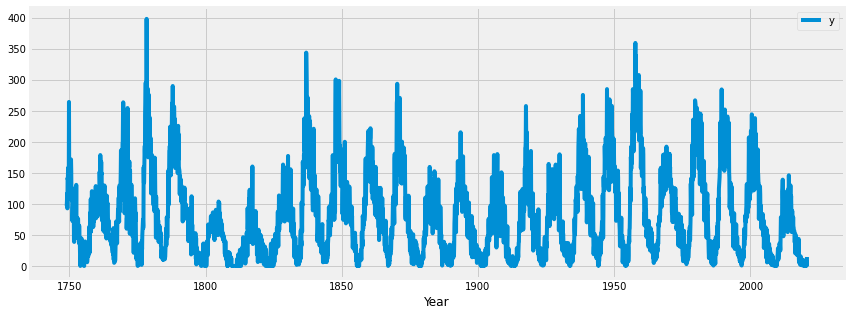

In [15]:
sunspot.plot(x="YM_Frac", xlabel="Year", y="y", figsize=(13,5));

# Data Preprocessing
This step is where we remove columns we do not need, check for missing values, aggregate the observations by the appropriate unit of time, etc. Most of the preprocessing fortunately has been addressed by our query selection, however, we will be resetting our index to the **ds** column and adjusting the datetime formatting.

In [47]:
# create ds datetime column by combining Year and Month
sunspot["ds"] = pd.to_datetime(sunspot[["Year", "Month"]].assign(Day=1))
# drop all unecessary columns
sunspot.drop(["Year","Month","YM_Frac", "Std", "Obs", "DP"], 
        axis=1, 
        inplace=True
)
# set the index to the ds column
sunspot.set_index("ds", inplace=True)
# update index frequency to monthly
sunspot.index.freq = "MS"

In [48]:
sunspot.index

DatetimeIndex(['1749-01-01', '1749-02-01', '1749-03-01', '1749-04-01',
               '1749-05-01', '1749-06-01', '1749-07-01', '1749-08-01',
               '1749-09-01', '1749-10-01',
               ...
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='ds', length=3262, freq='MS')

As mentioned in the introduction time series are often modeled as a linear combination of separate components. We can decompose a time series data set into its trend, seasonal, and residual components as shown below using the **seasonal_decompose** function from the statsmodels library.

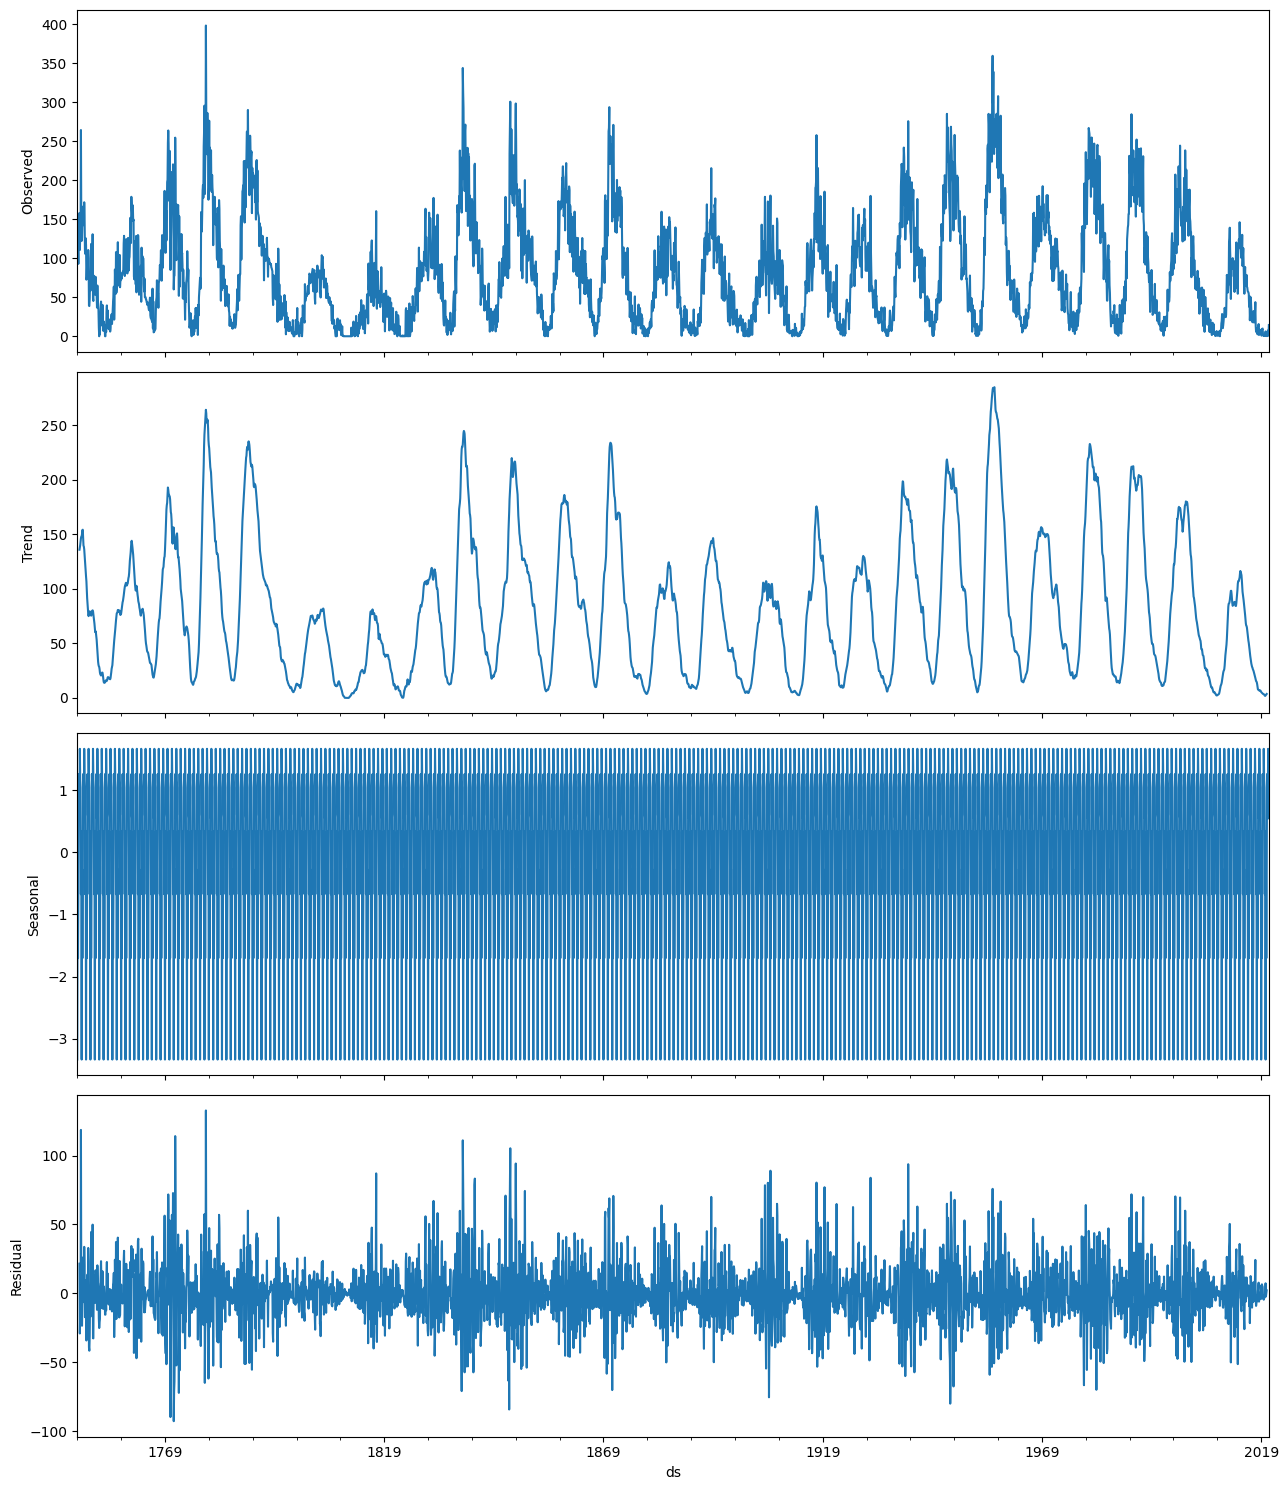

In [49]:
rcParams["figure.figsize"] = 13,15

decomposition = sm.tsa.seasonal_decompose(sunspot, model = "additive")
fig = decomposition.plot()
plt.show()

We can see signs of clear seasonality at different levels. The seasonal decomposition accounts for the annual cycle but we can also see what appears to be a 10 year cycle and then an even broader 100 year cycle. Most use cases for time series analysis do not occur on such a large scale lets take a look at a different dataset such as Google stock values over the last 10 years. 

## Google Stocks (GOOG)

Using the yfinance package to obtain the last 4 years of stock value data for the Google ticker (GOOG)

In [82]:
import yfinance as yf

tickerSymbol = 'GOOG'
tickerData = yf.Ticker(tickerSymbol)
goog = tickerData.history(period='1d', start='2016-12-01', end='2020-12-01')
goog

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-12-01,757.440002,759.849976,737.025024,747.919983,3017900,0,0
2016-12-02,744.590027,754.000000,743.099976,750.500000,1452500,0,0
2016-12-05,757.710022,763.900024,752.900024,762.520020,1394200,0,0
2016-12-06,764.729980,768.830017,757.340027,759.109985,1690700,0,0
2016-12-07,761.000000,771.359985,755.799988,771.190002,1761000,0,0
...,...,...,...,...,...,...,...
2020-11-23,1749.599976,1753.900024,1717.719971,1734.859985,2161600,0,0
2020-11-24,1730.500000,1771.599976,1727.689941,1768.880005,1578000,0,0
2020-11-25,1772.890015,1778.540039,1756.540039,1771.430054,1045800,0,0


Just as we did with the sunspot dataset we will need to preprocess the data by removing unnecessary variables, renaming columns, and ensuring we have the correct data types. 

In [78]:
goog.drop(["High","Low","Dividends"], axis=1, inplace=True)

In [64]:
goog.dtypes

Open            float64
Close           float64
Volume            int64
Stock Splits    float64
dtype: object

In [79]:
goog.index

DatetimeIndex(['2016-12-01', '2016-12-02', '2016-12-05', '2016-12-06',
               '2016-12-07', '2016-12-08', '2016-12-09', '2016-12-12',
               '2016-12-13', '2016-12-14',
               ...
               '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19',
               '2020-11-20', '2020-11-23', '2020-11-24', '2020-11-25',
               '2020-11-27', '2020-11-30'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)

Notice that the frequence is set to None because the data is only available for days the stock market was opened. We will cast the frequency as daily and fill in the null values using the backfill method which just takes the previous days value and carries it forward. 

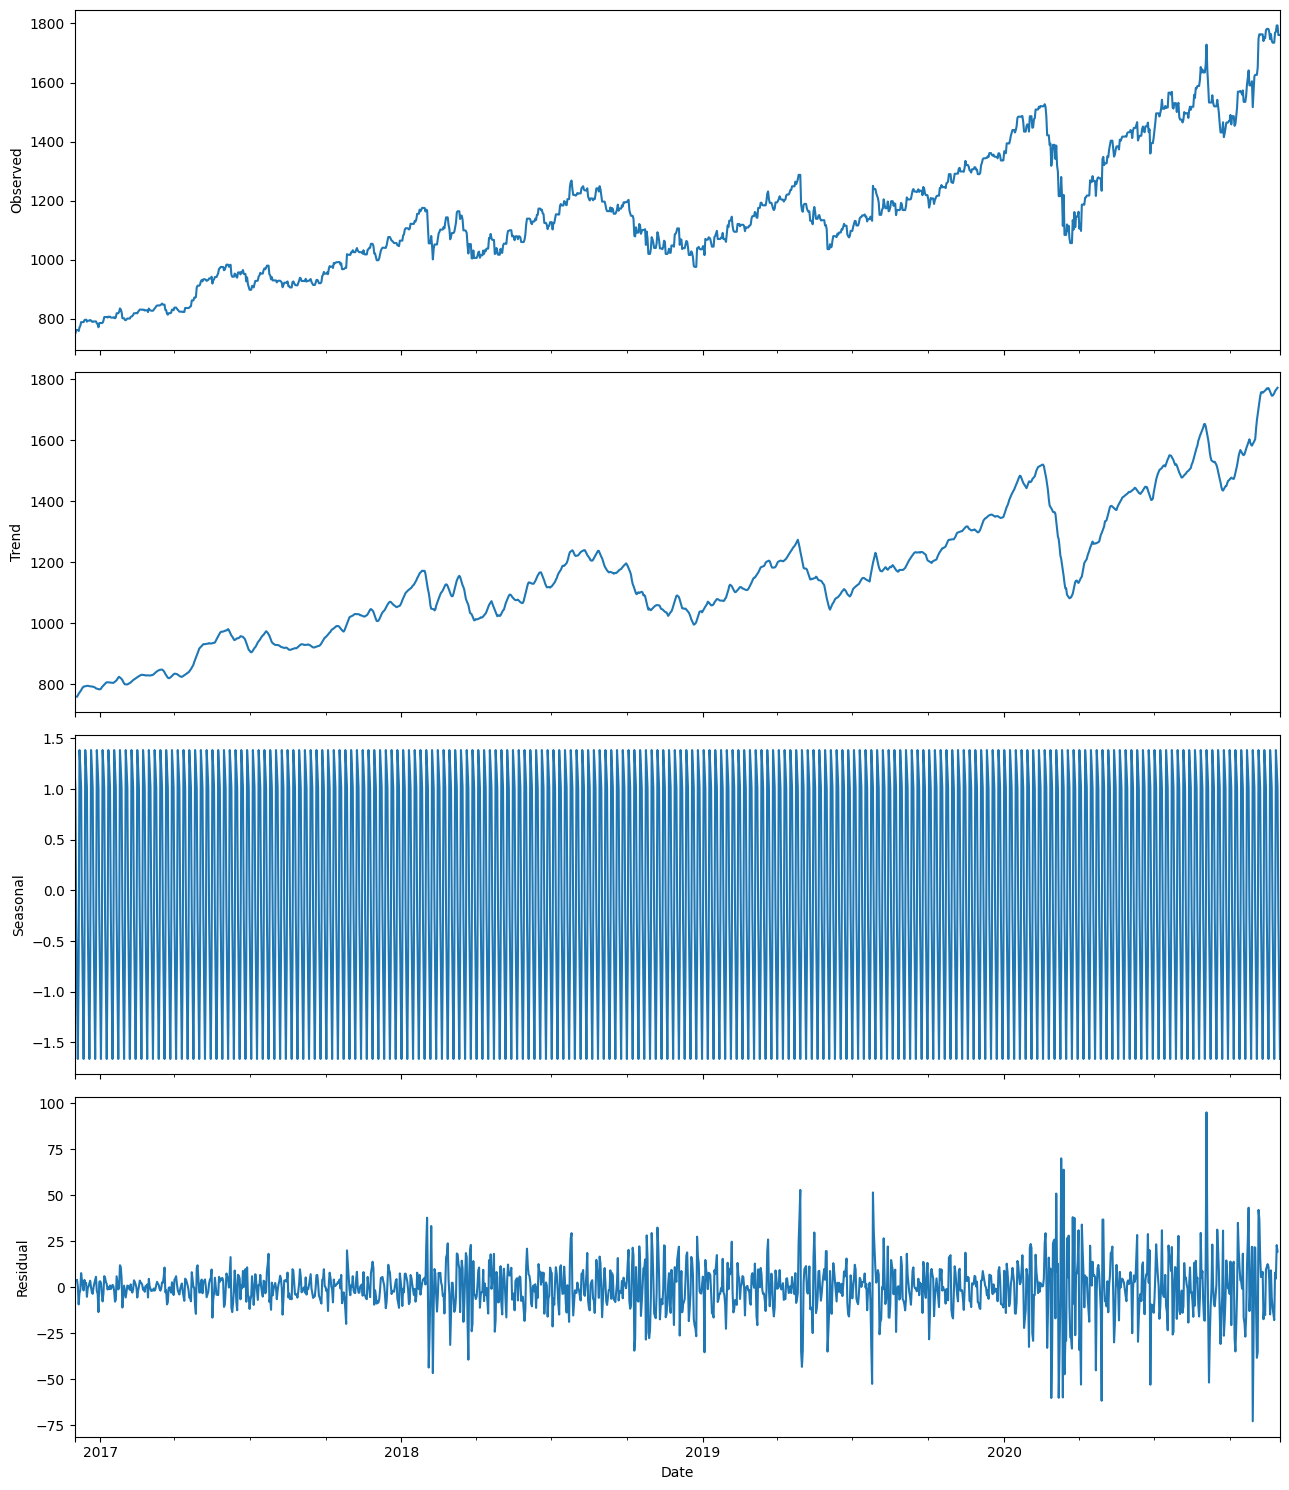

In [81]:
decomposition = sm.tsa.seasonal_decompose(goog['Close'].asfreq('D').fillna(method='bfill'), model = "additive")
fig = decomposition.plot()
plt.show()

Just like in the case of the sunspot dataset the GOOG stock price at close follows a very regular seasonality based on the frequency of that cycle it appears to be weekly. Taking a quick glance at the residual plot and we observe an increase in volatility particularly since the beginning of 2020 which we all know is associated with the COVID-19 pandemic. 